In [ ]:
# Imports
import os
import time
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# sklearn
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Load data from Google Drive
import gdown

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/MyDrive/data_209b_project/
! ls /content/drive/MyDrive/data_209b_project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ntmDM5EvtN6NojyJ5B0k3sKUVUL-BnbA/data_209b_project
 albert_loading.ipynb		   images_06.tar.gz
 albert_test_images		   images_07.tar.gz
 albert_train_val_images	   images_08.tar.gz
 albert_view_images.ipynb	   images_09.tar.gz
 ania_downloading_to_colab.ipynb   images_10.tar.gz
 ania_read_images.ipynb		   images_11.tar.gz
 ARXIV_V5_CHESTXRAY.pdf		   images_12.tar.gz
 BBox_List_2017.csv		   images_small_test
'Copy of EDA_Milestone2.ipynb'	   images_small_test.tar
 Data_Entry_2017_v2020.csv	   images_small_train_val
 downloading_data_209.ipynb	   images_small_train_val.tar
 EDA.ipynb			   LOG_CHESTXRAY.pdf
 EDA_Milestone2.ipynb		   naive_classifier.ipynb
 FAQ_CHESTXRAY.pdf		   plot2.pdf
 images				   README_CHESTXRAY.pdf
 images_01.tar.gz		   test_list.txt
 images_02.tar.gz		  'To Dos (1).gdoc'
 images_03.tar.gz		  'To Dos.gdoc'
 images_04.tar.gz		   train_val_list.txt
 images_05.tar.gz		   Untitled0.ipynb


In [ ]:
!tar -xvf /content/drive/MyDrive/data_209b_project/images_small_train_val.tar

Streaming output truncated to the last 5000 lines.
images_small_train_val/00010613_002.png
images_small_train_val/00024689_000.png
images_small_train_val/00003006_004.png
images_small_train_val/00017399_000.png
images_small_train_val/00010930_000.png
images_small_train_val/00019643_015.png
images_small_train_val/00021023_005.png
images_small_train_val/00014050_003.png
images_small_train_val/00002073_001.png
images_small_train_val/00002911_000.png
images_small_train_val/00019087_013.png
images_small_train_val/00022351_000.png
images_small_train_val/00009021_001.png
images_small_train_val/00006313_000.png
images_small_train_val/00003879_002.png
images_small_train_val/00030370_000.png
images_small_train_val/00015856_004.png
images_small_train_val/00020055_001.png
images_small_train_val/00001309_000.png
images_small_train_val/00023601_001.png
images_small_train_val/00014332_000.png
images_small_train_val/00017835_005.png
images_small_train_val/00023080_000.png
images_small_train_val/000220

# AC209B - FINAL PROJECT
# MILESTONE 2 - EDA and Naive Model

## Load data

In [ ]:
def print_data_info(name, df):
  print("##############################################")
  print(name)
  display(df.head())
  print("")
  print("No. of obs: ", len(df))
  print("No. of columns: ", len(df.columns), "\n")
  print(df.dtypes)

In [ ]:
# train-validation list
train_val_list = pd.read_csv('train_val_list.txt', header=None, names=['index'])

# load label data - training and validation only
labels = pd.read_csv('Data_Entry_2017_v2020.csv')
labels = labels[labels['Image Index'].isin(train_val_list['index'])]
labels = labels.rename(columns={'OriginalImage[Width':'Width','Height]':'Height','OriginalImagePixelSpacing[x':'SpacingX','y]':'SpacingY'})
print_data_info("LABELS", labels)

# load boxes data - not in training-validation set - should we even touch?
boxes = pd.read_csv('BBox_List_2017.csv')
boxes = boxes.rename(columns={'Bbox [x':'BboxX', 'y': 'BboxY', 'w':'BboxW', 'h]':'BboxH'})
print_data_info("BBOXES", boxes)

##############################################
LABELS


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Width,Height,SpacingX,SpacingY
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168



No. of obs:  86524
No. of columns:  11 

Image Index        object
Finding Labels     object
Follow-up #         int64
Patient ID          int64
Patient Age         int64
Patient Gender     object
View Position      object
Width               int64
Height              int64
SpacingX          float64
SpacingY          float64
dtype: object
##############################################
BBOXES


,Image Index,Finding Label,BboxX,BboxY,BboxW,BboxH,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN



No. of obs:  984
No. of columns:  9 

Image Index       object
Finding Label     object
BboxX            float64
BboxY            float64
BboxW            float64
BboxH            float64
Unnamed: 6       float64
Unnamed: 7       float64
Unnamed: 8       float64
dtype: object


## EDA: Investigate Patient ID and Finding Labels variables
First, we want to take a closer look athe the Patient ID and Finding Labels variables to see how the dataset is organized

* Data consists of XRay images from 30,805 patients.
* Each patient has on average 3.64 images in the data, ranging from 1 per patient to 184. Each follow-up visit correspond to one image for each patient.

In [ ]:
# count number of patients in data
print("Number of unique patients in data set: ", len(labels['Patient ID'].unique()))
print("Number of images in data set: ", len(labels))
perpatient = labels.groupby('Patient ID',as_index=False).size()
print(f"Average no. of images per patient: {perpatient['size'].mean(): .2f}")
print(f"Patients has {perpatient['size'].min()} - {perpatient['size'].max()} images")

Number of unique patients in data set:  28008
Number of images in data set:  86524
Average no. of images per patient:  3.09
Patients has 1 - 109 images


* Diagnosis labels might contain a single label, or a combination of multiple labels.
  * 81.45% of observations has single label, 18.55% has multiple labels.
* Two potential way to deal with this issue:
  * Restrict model to predict on single label images only
  * Consider all images.

* For the purpose of EDA, we'll create two datasets, one with single label and one with all data, so that we can explore both.
  * We need to turn label into one-hot-encoded arrays to accommodate both dataset format.
  * This means that for the dataset containing all images, we'll have a one-hot-encoded array of 15 columns.

In [ ]:
# number of images with multiple labels
single, single_p = len(labels[~labels['Finding Labels'].str.contains('|', regex=False)]), len(labels[~labels['Finding Labels'].str.contains('|', regex=False)])/len(labels)
multi, multi_p = len(labels[labels['Finding Labels'].str.contains('|', regex=False)]), len(labels[labels['Finding Labels'].str.contains('|', regex=False)])/len(labels)
print(f"Images with single label: {single} ({100*single_p: .2f}%)")
print(f"Images with multiple label:s {multi} ({100*multi_p: .2f}%)")

# list of all unique labels
label_list = "|".join([i for i in labels['Finding Labels'].unique()])
label_list = set(label_list.split("|"))
print(f"Number of unique labels: {len(label_list)}")

Images with single label: 73471 ( 84.91%)
Images with multiple label:s 13053 ( 15.09%)
Number of unique labels: 15


* Turn Finding Labels column into one-hot-encoded array and create 2 dataframes

In [ ]:
# function to one-hot-encode and return dataset with desired set of observation
def one_hot_encode_label(df=labels, label_type='all', label_col='Finding Labels'):
  """ Return data from with one-hot-encoded labels
  """
  out = df.copy()
  label_list = "|".join([i for i in labels['Finding Labels'].unique()])
  label_list = set(label_list.split("|"))
  for i in label_list:
    col_name = "label_" + i
    out[col_name] = df[label_col].str.contains(i)
  out['count_label'] = out[["label_"+i for i in label_list]].sum(axis=1)
  if label_type=='single':
    return out[out['count_label'] == 1]
  elif label_type=='multi':
    return out[out['count_label'] > 1]
  elif label_type=='all':
    return out

In [ ]:
labels_all = one_hot_encode_label()
labels_single = one_hot_encode_label(df=labels, label_type='single')

## EDA: Distribution of Labels
Next, we want to see the proportion of each label in the dataset.

* From the plot below, we can see there the data is heavily imbalanced. The vast majority of the images are labeled "No Finding", which suggest that most of the images in our data does not exhibit any symtom of images. 
* This is something that we should take into account in our modeling, through a reweighting scheme. 

In [ ]:
# create frequency tables of images by labels using "one-hot-encoded" dataset
def frequency_table(df):
  label_cols = [i for i in df.columns if "label_" in i]
  d = {'Label': [i[6:] for i in label_cols], 
       'No. of Images': [df[i].sum() for i in label_cols], 
       'Percent of Images': [100*df[i].sum()/len(df) for i in label_cols]}
  return pd.DataFrame(data=d) 

def barplot_freq(df, var, ax):
    data = df.sort_values(by='Percent of Images',ascending=False)
    cmap = plt.cm.get_cmap('tab20', len(data))
    for c,(w,x,y) in enumerate(zip(data[var], data['No. of Images'], data['Percent of Images'])):
        ax.bar(w, x+4, width=0.5, edgecolor='black', color = cmap(c), align = 'center', alpha = 0.5, label = w)
        ax.text(w,x, str(round(y)) + '%', ha='center', fontsize=12)
    ax.grid(axis='y')
    ax.xaxis.set_visible(False)
    #ax.set_title(var, fontsize=15)
    ax.set_ylabel("No. of images")
    ax.legend(ncol=2, fontsize=10)
    
    return ax 

def barplot(df, var, ax):
  gender = df.groupby([var], as_index=False).size()
  gender['pct'] = 100*gender['size']/gender['size'].sum()
  cmap = plt.cm.get_cmap('tab20', len(gender))
  for c,(w,x,y) in enumerate(zip(gender[var], gender['size'], gender['pct'])):
      ax.bar(w, x+4, width=0.5, edgecolor='black', color = cmap(c), align = 'center', alpha = 0.5, label = w)
      ax.text(w,x, str(round(y)) + '%', ha='center', fontsize=12)
  ax.grid(axis='y')
  ax.xaxis.set_visible(False)
  ax.set_ylabel("No. of images")
  ax.legend(ncol=2, fontsize=10)
  return ax

In [ ]:
freq = frequency_table(labels_all)
print("Frequency of Labels for All Images")
display(freq)

Frequency of Labels for All Images


,Label,No. of Images,Percent of Images
0,No Finding,50500,58.365309
1,Pleural_Thickening,2242,2.591189
2,Nodule,4708,5.441265
3,Infiltration,13782,15.928529
4,Edema,1378,1.592622
5,Mass,4034,4.662290
6,Pneumonia,876,1.012436
7,Emphysema,1423,1.644630
8,Effusion,8659,10.007628
9,Pneumothorax,2637,3.047709


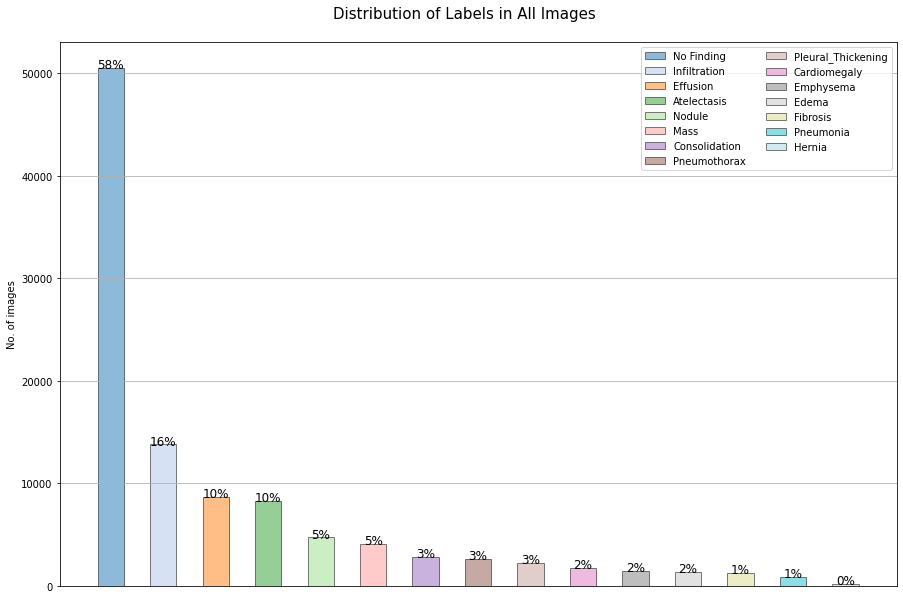

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
fig.suptitle("Distribution of Labels in All Images",y=0.93,fontsize=15)
barplot_freq(freq, 'Label',  ax) 
plt.show()

In [ ]:
freq = frequency_table(labels_single)
print("Frequency of Labels for Single-labeled Images")
display(freq)

Frequency of Labels for Single-labeled Images


,Label,No. of Images,Percent of Images
0,No Finding,50500,68.734603
1,Pleural_Thickening,817,1.112003
2,Nodule,2248,3.059711
3,Infiltration,7327,9.972642
4,Edema,397,0.540349
5,Mass,1696,2.308394
6,Pneumonia,234,0.318493
7,Emphysema,587,0.798955
8,Effusion,2788,3.794695
9,Pneumothorax,1241,1.689102


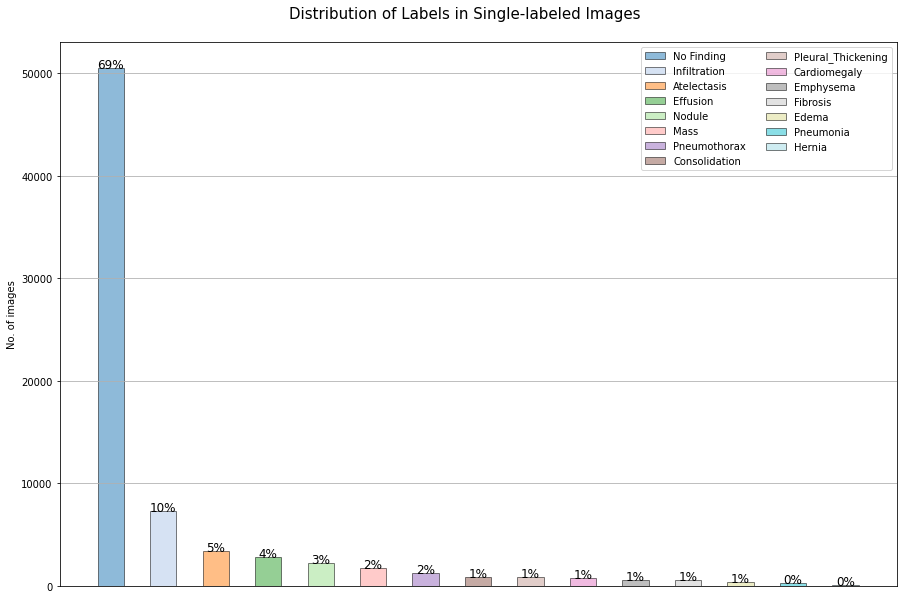

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
fig.suptitle("Distribution of Labels in Single-labeled Images",y=0.93,fontsize=15)
barplot_freq(freq, 'Label',  ax) 
plt.show()

## EDA: Distribution of Patient Variables

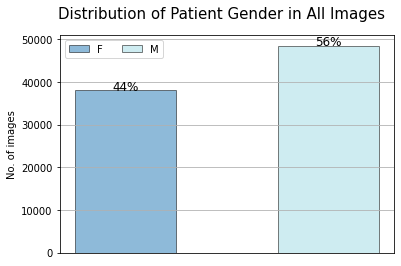

In [ ]:
# Distribution of gender
fig, ax = plt.subplots(1,1)
barplot(labels_all, 'Patient Gender', ax)
fig.suptitle("Distribution of Patient Gender in All Images", fontsize=15)
plt.show()

In [ ]:
labels_all[labels_all['label_Nodule']==1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Width,Height,SpacingX,...,label_Pneumonia,label_Emphysema,label_Effusion,label_Pneumothorax,label_Atelectasis,label_Fibrosis,label_Consolidation,label_Cardiomegaly,label_Hernia,count_label
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168000,...,False,False,False,False,False,False,False,False,False,2
25,00000008_002.png,Nodule,2,8,72,F,PA,2048,2500,0.168000,...,False,False,False,False,False,False,False,False,False,1
88,00000017_000.png,Effusion|Infiltration|Nodule,0,17,77,M,PA,2500,2048,0.168000,...,False,False,True,False,False,False,False,False,False,3
96,00000021_000.png,Nodule,0,21,77,M,PA,2500,2048,0.168000,...,False,False,False,False,False,False,False,False,False,1
104,00000023_004.png,Infiltration|Mass|Nodule,4,23,63,F,PA,2500,2048,0.168000,...,False,False,False,False,False,False,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111976,00030703_001.png,Nodule,1,30703,57,F,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,1
111990,00030715_000.png,Consolidation|Nodule,0,30715,48,F,PA,2021,2021,0.194311,...,False,False,False,False,False,False,True,False,False,2
112001,00030722_000.png,Nodule,0,30722,45,F,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,1
112005,00030726_000.png,Nodule,0,30726,63,M,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,1


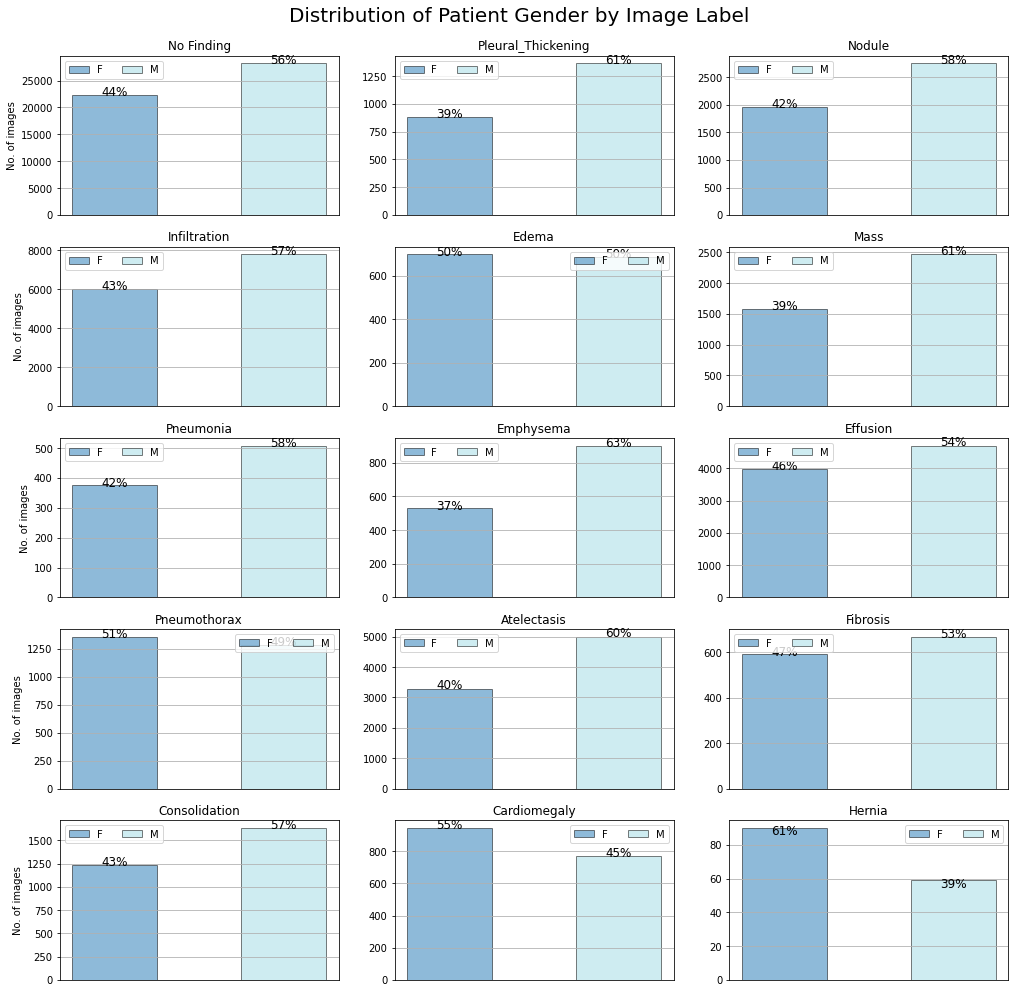

In [ ]:
# Distribution of Gender by Labels
fig, ax = plt.subplots(5,3, figsize=(17,17))
fig.suptitle("Distribution of Patient Gender by Image Label", fontsize=20, y=0.92)
ax = ax.flatten()
label_cols = [i for i in labels_all.columns if "label_" in i]
for i, label in enumerate(label_cols):
  title = label[6:]
  subset = labels_all[labels_all[label]==1]
  barplot(subset,'Patient Gender', ax[i])
  if i%3:
    ax[i].set_ylabel("")
  ax[i].set_title(title)
plt.show()

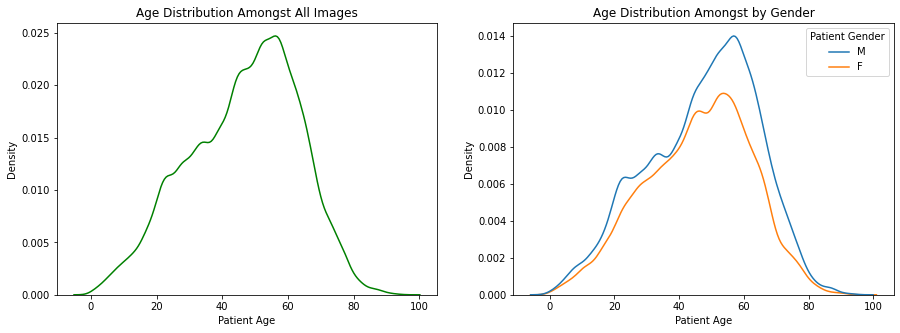

In [ ]:
# Distribution of Age
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(ax=ax[0], data=labels_all, x='Patient Age', color = 'green')
ax[0].set_title("Age Distribution Amongst All Images")
sns.kdeplot(ax=ax[1], data=labels_all, x="Patient Age", hue="Patient Gender")
ax[1].set_title("Age Distribution Amongst by Gender")
plt.show()

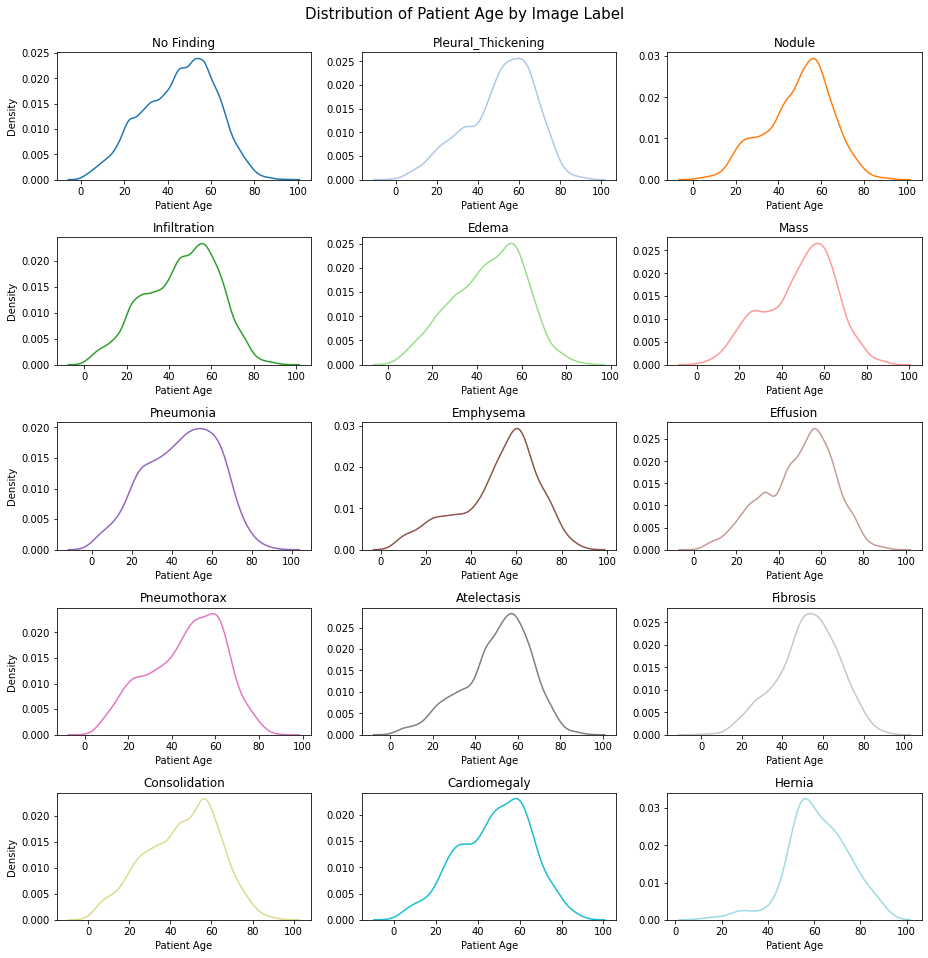

In [ ]:
# Distribution of Age by Label
fig, ax = plt.subplots(5,3, figsize=(13,13))
fig.suptitle("Distribution of Patient Age by Image Label", fontsize=15, y=1.02)
ax = ax.flatten()
label_cols = [i for i in labels_all.columns if "label_" in i]
cmap = plt.cm.get_cmap('tab20', len(label_cols))
for i, label in enumerate(label_cols):
  title = label[6:]
  subset = labels_all[labels_all[label]==1]
  sns.kdeplot(ax=ax[i], data=subset, x="Patient Age", color = cmap(i))
  if i%3:
    ax[i].set_ylabel("")
  ax[i].set_title(title)
fig.tight_layout()
plt.show()


## EDA: Explore Images

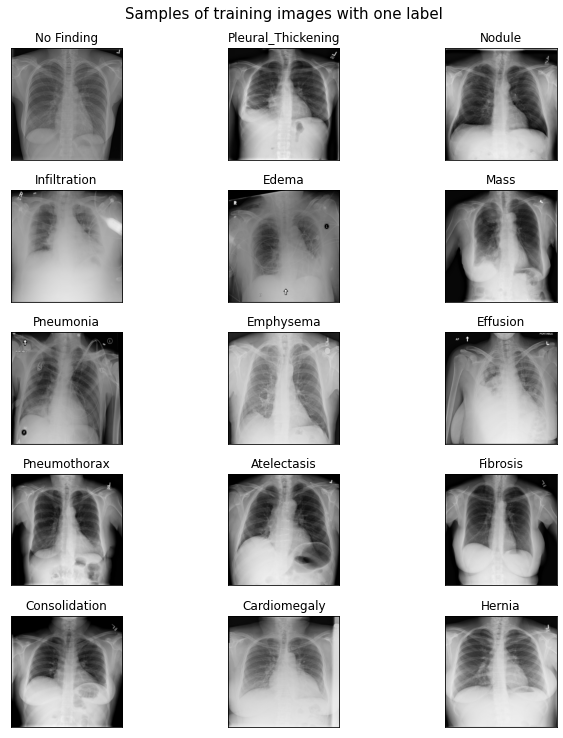

In [ ]:
# visualize images from each labels
# single label images:
import random

index = [labels_single[labels_single['Finding Labels'] == i]['Image Index'].tolist() for i in label_list]
index = [random.choice(i) for i in index]
images = [cv2.imread("images_small_train_val/"+id) for id in index]
fig, ax = plt.subplots(5,3,figsize=(10,10))
fig.suptitle("Samples of training images with one label", fontsize=15, y=1.02)
ax = ax.flatten()
for i, im in enumerate(images):
  ax[i].imshow(im)
  ax[i].set_title(list(label_list)[i])
  ax[i].set_yticks([])
  ax[i].set_xticks([])
fig.tight_layout()
plt.show()

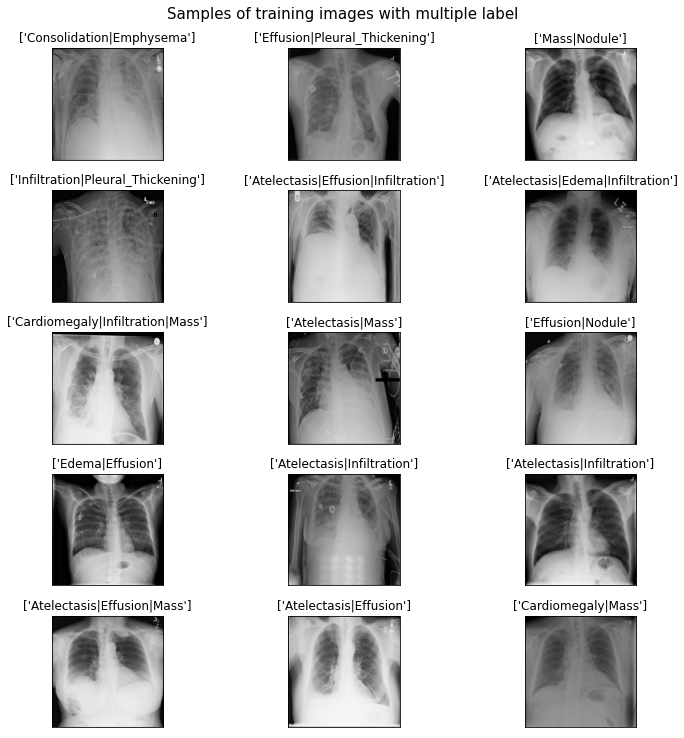

In [ ]:
# smaples of images with multiple labels
index = labels_all[labels_all['Finding Labels'].str.contains("|", regex=False)]['Image Index'].tolist()
index = random.sample(index,15)
images = [cv2.imread("images_small_train_val/"+id) for id in index]
fig, ax = plt.subplots(5,3,figsize=(10,10))
fig.suptitle("Samples of training images with multiple label", fontsize=15, y=1.02)
ax = ax.flatten()
for i, im in enumerate(images):
  title = labels_all['Finding Labels'].values[labels_all['Image Index'] == index[i]]
  ax[i].imshow(im)
  ax[i].set_title(title, wrap=True)
  ax[i].set_yticks([])
  ax[i].set_xticks([])
fig.tight_layout()
plt.show()

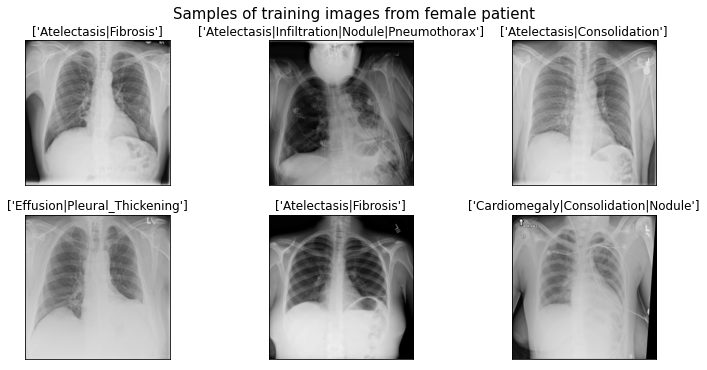

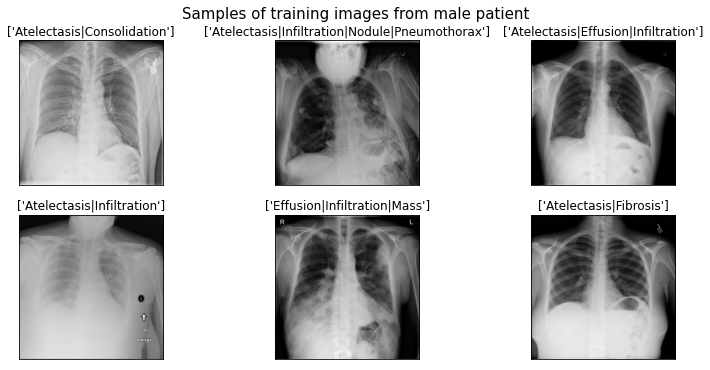

In [ ]:
# samples of images from male/female
index_f = labels_all[labels_all['Patient Gender']=='F']['Image Index'].tolist()
index_f = random.sample(index,6)
index_m = labels_all[labels_all['Patient Gender']=='M']['Image Index'].tolist()
index_m = random.sample(index,6)

images_f = [cv2.imread("images_small_train_val/"+id) for id in index_f]
images_m = [cv2.imread("images_small_train_val/"+id) for id in index_m]

fig, ax = plt.subplots(2,3,figsize=(10,5))
fig.suptitle("Samples of training images from female patient", fontsize=15, y=1.02)
ax = ax.flatten()
for i, im in enumerate(images_f):
  title=labels_all['Finding Labels'].values[labels_all['Image Index'] == index_f[i]]
  ax[i].imshow(im)
  ax[i].set_title(title)
  ax[i].set_yticks([])
  ax[i].set_xticks([])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(2,3,figsize=(10,5))
fig.suptitle("Samples of training images from male patient", fontsize=15, y=1.02)
ax = ax.flatten()
for i, im in enumerate(images_m):
  title=labels_all['Finding Labels'].values[labels_all['Image Index'] == index_m[i]]
  ax[i].imshow(im)
  ax[i].set_title(title)
  ax[i].set_yticks([])
  ax[i].set_xticks([])
fig.tight_layout()
plt.show()

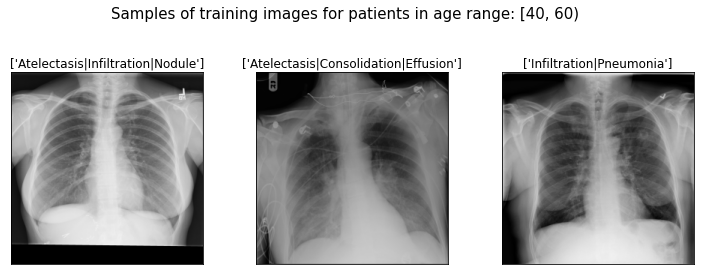

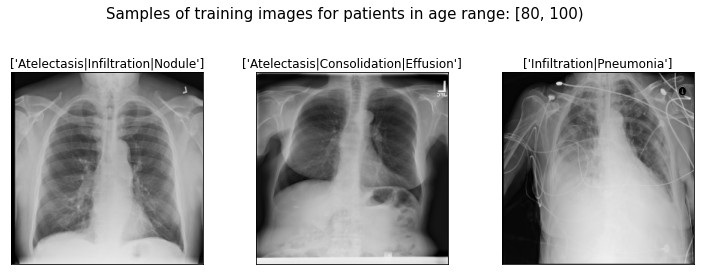

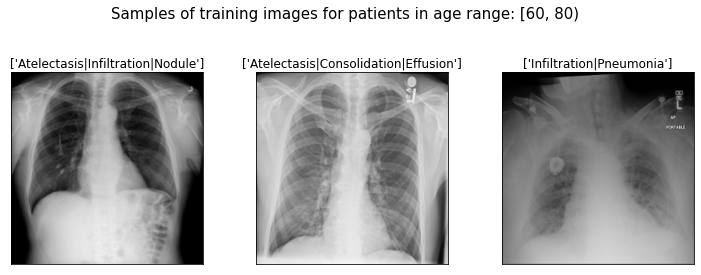

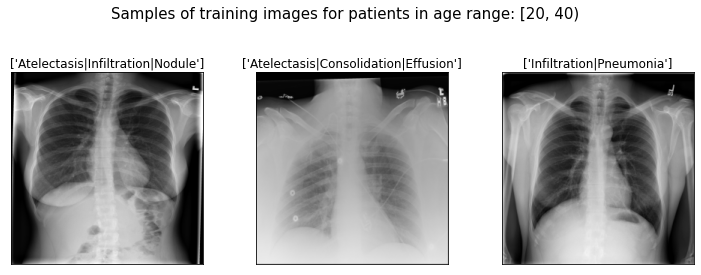

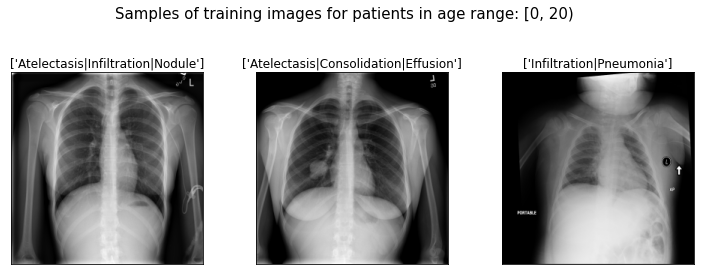

In [ ]:
# samples of images from male/female
labels_all['age_bin'] = pd.cut(labels['Patient Age'], [0,20,40,60,80,100], right=False)
index = [labels_all[labels_all['age_bin'] == i]['Image Index'].tolist() for i in labels_all['age_bin'].unique()]
index = [random.sample(i,3) for i in index]

for i, age_bin in enumerate(index):
  images = [cv2.imread("images_small_train_val/"+id) for id in age_bin]
  fig, ax = plt.subplots(1,3,figsize=(10,5))
  fig.suptitle(f"Samples of training images for patients in age range: {labels_all['age_bin'].unique()[i]}", fontsize=15, y=0.95)
  ax = ax.flatten()
  for i, im in enumerate(images):
    title=labels_all['Finding Labels'].values[labels_all['Image Index'] == index_f[i]]
    ax[i].imshow(im)
    ax[i].set_title(title)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
  fig.tight_layout()
  plt.show()

## Baseline results: Naive Classifier 


In [ ]:
#Create label dictionary 
label_dict = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration': 3, 'Mass': 4, 
 'Nodule': 5, 'Pneumonia': 6,  'Pneumothorax': 7 , 'No Finding':9, 'others': 10}

inverse_dict = {v:k for  (k, v) in label_dict.items()}

#remap labels 
original_labels = labels_all['Finding Labels']
mapped_labels = [label_dict[label] if label in label_dict else 10 for label in original_labels]

In [ ]:
#naive classifier - most frequent 
## “most_frequent”: the predict method always returns the most frequent class label in the observed y argument passed to fit.
X = np.ones(shape=labels_all.shape[0])
y = mapped_labels
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
y_pred = dummy_clf.predict(X)
print(classification_report(y, y_pred));

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3414
           1       0.00      0.00      0.00       777
           2       0.00      0.00      0.00      2788
           3       0.00      0.00      0.00      7327
           4       0.00      0.00      0.00      1696
           5       0.00      0.00      0.00      2248
           6       0.00      0.00      0.00       234
           7       0.00      0.00      0.00      1241
           9       0.58      1.00      0.74     50500
          10       0.00      0.00      0.00     16299

    accuracy                           0.58     86524
   macro avg       0.06      0.10      0.07     86524
weighted avg       0.34      0.58      0.43     86524



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
